# Librairies

In [37]:
import datetime
import folium
from folium.features import GeoJsonPopup   
from folium import Choropleth
from folium.plugins import BeautifyIcon
import geopandas as gpd
from geopandas import sjoin
import holidays
import json
from math import pi
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors     
import matplotlib.cm as cm  
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
pd.set_option('display.max_columns', None) 
sns.set_style("white")
sns.despine()

<Figure size 640x480 with 0 Axes>

# Data wrangling

In [38]:
# Gathering data
#LesAkt_df = pd.read_csv('LesAkt_240717-250717.csv', sep='~')
# Relire directement le CSV en forçant le type string
LesAkt_df = pd.read_csv('LesAkt_240717-250717.csv', sep='~', dtype={'Verkehrzelle': str})

# S'assurer que toutes les valeurs sont sur 5 caractères (complète avec des 0 devant)
LesAkt_df["Verkehrzelle"] = LesAkt_df["Verkehrzelle"].str.zfill(5)
LesAkt_df

Sigel  Benutzergruppe Geschlecht  Alter Verkehrzelle      PLZ  \
0       462             1.0          W   52.0        16112  13187.0   
1       844             3.0          M   28.0        00212  10551.0   
2       983             1.0          M   57.0        16511  13156.0   
3       462             6.0          M    8.0        16614  13127.0   
4       462             1.0          W   39.0        16011  13187.0   
...     ...             ...        ...    ...          ...      ...   
46112  OPAC             1.0          W   54.0        11023  10405.0   
46113   971             6.0          W    9.0        10741  10439.0   
46114   462             6.0          M    8.0        16122  13187.0   
46115   458             6.0          W   16.0        11621  10245.0   
46116   471             6.0          M    3.0        17013  13125.0   

       Ausweisgueltigkeit  zuletzt aktiv Nationalitaet  Anzahl  
0              20251104.0       20250620            DE       1  
1              20251015.0       20250106           NaN       1  
2              20251106.0       20250704            DE       1  
3              20260106.0       20250106            DE       1  
4              20260722.0       20250707            DE       1  
...                   ...            ...           ...     ...  
46112          20260125.0       20250515            DE       1  
46113          20250924.0       20250704            DE       1  
46114          20260206.0       20250426            DE       1  
46115          20250521.0       20240913            DE       1  
46116          20260414.0       20250621            DE       1  

[46117 rows x 10 columns]

In [39]:
# corriger le nom des colonnes
LesAkt_df = LesAkt_df.rename(columns={
    "Ausweisgueltigkeit": "Ausweisgültigkeit",
    "zuletzt aktiv": "zuletzt_aktiv",
    "Nationalitaet": "Nationalität"
})
LesAkt_df.head(3)

Sigel  Benutzergruppe Geschlecht  Alter Verkehrzelle      PLZ  \
0   462             1.0          W   52.0        16112  13187.0   
1   844             3.0          M   28.0        00212  10551.0   
2   983             1.0          M   57.0        16511  13156.0   

   Ausweisgültigkeit  zuletzt_aktiv Nationalität  Anzahl  
0         20251104.0       20250620           DE       1  
1         20251015.0       20250106          NaN       1  
2         20251106.0       20250704           DE       1

In [40]:
# Charger CSV
Alter_Geschlecht_df = pd.read_csv("Alter vs Geschlecht.csv", sep=';')

# Mettre la colonne Altersgruppe comme index
Alter_Geschlecht_df = Alter_Geschlecht_df.set_index("Altersgruppe")

# Harmoniser les labels si besoin (exemple : "65+" → "65 und mehr")
mapping = {
    "0 - 6": "0-6",
    "6-15": "6 - 15",
    "65+": "65 und mehr"
}
Alter_Geschlecht_df = Alter_Geschlecht_df.rename(index=mapping)

# Réindexer dans l'ordre défini par age_labels
#Alter_Geschlecht_df = Alter_Geschlecht_df.reindex(age_labels, fill_value=0)


In [41]:
print(Alter_Geschlecht_df.head())
print(Alter_Geschlecht_df.index)

              Männlich  Weiblich
Altersgruppe                    
0-6              11656     11112
6 - 15           19396     18705
15 - 18           6367      5980
18 - 20           4031      3603
20 - 25          10622     10502
Index(['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', '25 - 30', '30 - 35',
       '35 - 40', '40 - 45', '45 - 60', '60 - 65', '65 und mehr'],
      dtype='object', name='Altersgruppe')


# Data cleaning

In [42]:
LesAkt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46117 entries, 0 to 46116
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sigel              46106 non-null  object 
 1   Benutzergruppe     46116 non-null  float64
 2   Geschlecht         44882 non-null  object 
 3   Alter              44871 non-null  float64
 4   Verkehrzelle       39849 non-null  object 
 5   PLZ                46055 non-null  float64
 6   Ausweisgültigkeit  46116 non-null  float64
 7   zuletzt_aktiv      46117 non-null  int64  
 8   Nationalität       43249 non-null  object 
 9   Anzahl             46117 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 3.5+ MB


In [43]:
# conversion date en type datetime
LesAkt_df['Ausweisgültigkeit'] = (
    LesAkt_df['Ausweisgültigkeit']
    .astype('Int64')  # supprime le .0 tout en gérant les NaN
    .astype(str)      # en texte pour datetime
)

LesAkt_df['Ausweisgültigkeit'] = pd.to_datetime(
    LesAkt_df['Ausweisgültigkeit'],
    format='%Y%m%d',
    errors='coerce'
)

LesAkt_df['zuletzt_aktiv'] = (
    LesAkt_df['zuletzt_aktiv']
    .astype('Int64')  # supprime le .0 tout en gérant les NaN
    .astype(str)      # en texte pour datetime
)

LesAkt_df['zuletzt_aktiv'] = pd.to_datetime(
    LesAkt_df['zuletzt_aktiv'],
    format='%Y%m%d',
    errors='coerce'
)

In [44]:
# Datatype str pour Mediennummer
# LesAkt_df["Verkehrzelle"] = (
#     LesAkt_df["Verkehrzelle"]
#     .astype(float)  # au cas où il y ait encore du float
#     .astype("Int64") # Pandas integer nullable
#     .astype(str)    # en texte, pour éviter le .0
# )

LesAkt_df["PLZ"] = (
    LesAkt_df["PLZ"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

LesAkt_df["Benutzergruppe"] = (
    LesAkt_df["Benutzergruppe"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

In [45]:
# data types conversion
LesAkt_df.astype({
    'Alter': 'Int64'
}).dtypes
LesAkt_df = LesAkt_df.astype({
    'Alter': 'Int64'
})
LesAkt_df.dtypes

Sigel                        object
Benutzergruppe               object
Geschlecht                   object
Alter                         Int64
Verkehrzelle                 object
PLZ                          object
Ausweisgültigkeit    datetime64[ns]
zuletzt_aktiv        datetime64[ns]
Nationalität                 object
Anzahl                        int64
dtype: object

In [46]:
#test null values
print(LesAkt_df.isnull().sum())

Sigel                  11
Benutzergruppe          0
Geschlecht           1235
Alter                1246
Verkehrzelle         6268
PLZ                     0
Ausweisgültigkeit       1
zuletzt_aktiv           0
Nationalität         2868
Anzahl                  0
dtype: int64


In [47]:
# delete null values
LesAkt_df.dropna(subset=['Sigel'], inplace=True)
LesAkt_df.dropna(subset=['Benutzergruppe'], inplace=True)
LesAkt_df.dropna(subset=['Geschlecht'], inplace=True)
LesAkt_df.dropna(subset=['Alter'], inplace=True)
LesAkt_df.dropna(subset=['Ausweisgültigkeit'], inplace=True)
LesAkt_df.dropna(subset=['Nationalität'], inplace=True)
print(LesAkt_df.isnull().sum())


Sigel                   0
Benutzergruppe          0
Geschlecht              0
Alter                   0
Verkehrzelle         5721
PLZ                     0
Ausweisgültigkeit       0
zuletzt_aktiv           0
Nationalität            0
Anzahl                  0
dtype: int64


In [48]:
# test duplicate
duplicate_rows = LesAkt_df.duplicated().sum()
print(duplicate_rows)
# Pas de doublons.

0


In [49]:
# comptabiliser les valeurs uniques
LesAkt_df.nunique()

Sigel                 137
Benutzergruppe         10
Geschlecht              3
Alter                  99
Verkehrzelle          937
PLZ                   626
Ausweisgültigkeit    1473
zuletzt_aktiv         348
Nationalität          125
Anzahl                  5
dtype: int64

In [50]:
LesAkt_df

Sigel Benutzergruppe Geschlecht  Alter Verkehrzelle    PLZ  \
0       462              1          W     52        16112  13187   
2       983              1          M     57        16511  13156   
3       462              6          M      8        16614  13127   
4       462              1          W     39        16011  13187   
5       650              1          W     74        15615  13129   
...     ...            ...        ...    ...          ...    ...   
46112  OPAC              1          W     54        11023  10405   
46113   971              6          W      9        10741  10439   
46114   462              6          M      8        16122  13187   
46115   458              6          W     16        11621  10245   
46116   471              6          M      3        17013  13125   

      Ausweisgültigkeit zuletzt_aktiv Nationalität  Anzahl  
0            2025-11-04    2025-06-20           DE       1  
2            2025-11-06    2025-07-04           DE       1  
3            2026-01-06    2025-01-06           DE       1  
4            2026-07-22    2025-07-07           DE       1  
5            2026-05-19    2025-06-16           DE       1  
...                 ...           ...          ...     ...  
46112        2026-01-25    2025-05-15           DE       1  
46113        2025-09-24    2025-07-04           DE       1  
46114        2026-02-06    2025-04-26           DE       1  
46115        2025-05-21    2024-09-13           DE       1  
46116        2026-04-14    2025-06-21           DE       1  

[43220 rows x 10 columns]

In [51]:
LesAkt_df.shape
# ancien contenu LesAkt_df = 46.117 rows × 10 columns
# nouveau contenu LesAkt_df = 43.220.388 rows x 10 columns

(43220, 10)

In [52]:
LesAkt_df.describe()

Alter              Ausweisgültigkeit  \
count    43220.0                          43220   
mean   30.882878  2025-10-07 21:28:26.210087680   
min          0.0            1993-02-28 00:00:00   
25%         10.0            2025-09-03 00:00:00   
50%         30.0            2025-11-27 00:00:00   
75%         47.0            2026-03-10 00:00:00   
max         98.0            2045-10-30 00:00:00   
std    21.823165                            NaN   

                       zuletzt_aktiv        Anzahl  
count                          43220  43220.000000  
mean   2025-03-26 21:15:38.565479168      1.004142  
min              2024-07-17 00:00:00      1.000000  
25%              2025-01-10 00:00:00      1.000000  
50%              2025-05-02 00:00:00      1.000000  
75%              2025-06-27 00:00:00      1.000000  
max              2025-07-17 00:00:00     15.000000  
std                              NaN      0.097904

# Exploratory Data Analysis (EDA) 

Benutzergruppe         10
Geschlecht              3
Alter                  99
Nationalität          125

In [53]:
# Age pyramid
print(LesAkt_df["Geschlecht"].value_counts(dropna=False))

Geschlecht
W    26436
M    16647
K      137
Name: count, dtype: int64


In [54]:
Alter_Geschlecht_df

Männlich  Weiblich
Altersgruppe                    
0-6              11656     11112
6 - 15           19396     18705
15 - 18           6367      5980
18 - 20           4031      3603
20 - 25          10622     10502
25 - 30          14012     15202
30 - 35          17557     18410
35 - 40          20117     20808
40 - 45          18118     18555
45 - 60          47637     45968
60 - 65          13347     12257
65 und mehr      26913     36401

Pyramide des âges

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/1919932672.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/1919932672.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/1919932672.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


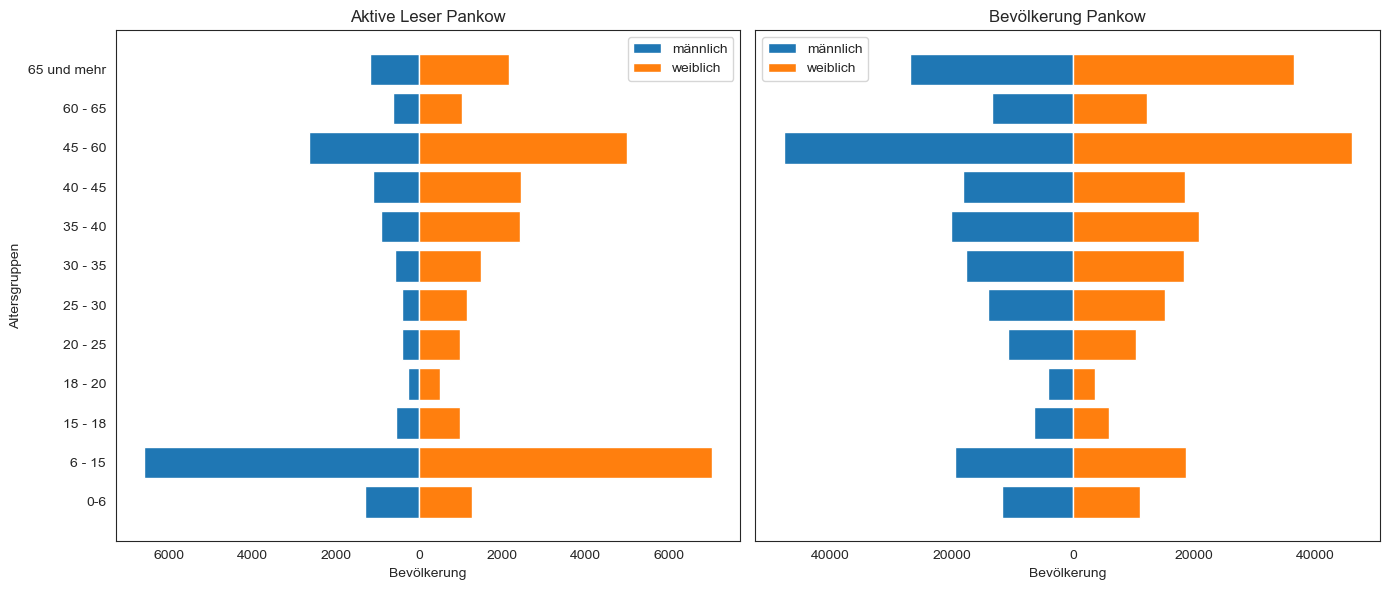

In [55]:

# Définir les tranches d'âge
age_labels = ['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', 
              '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 60', 
              '60 - 65', '65 und mehr']

# ---------------------------
# 1️⃣ Pyramide globale
# ---------------------------
# Catégoriser les âges avec les mêmes groupes que Pankow
LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=[0,6,15,18,20,25,30,35,40,45,60,65,200],
    labels=age_labels,
    right=False
)

# Grouper et remplir les valeurs manquantes avec 0
age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)

# S'assurer que toutes les tranches sont présentes
age_pyramid_global = age_pyramid_global.reindex(age_labels, fill_value=0)

# ---------------------------
# 2️⃣ Pyramide Pankow
# ---------------------------
# L'index est déjà Altersgruppe, on réindex juste pour être sûr de l'ordre
Alter_Geschlecht_df = Alter_Geschlecht_df.reindex(age_labels, fill_value=0)

# ---------------------------
# 3️⃣ Création du subplot
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)


# 🔹 Pyramide globale
ax = axes[0]
ax.barh(age_pyramid_global.index, -age_pyramid_global.get('M',0), label='männlich')
ax.barh(age_pyramid_global.index,  age_pyramid_global.get('W',0), label='weiblich')
ax.set_xlabel("Bevölkerung")
ax.set_ylabel("Altersgruppen")
ax.set_title("Aktive Leser Pankow")
ax.legend()
ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])

# 🔹 Pyramide Pankow
ax2 = axes[1]
ax2.barh(Alter_Geschlecht_df.index, -Alter_Geschlecht_df['Männlich'], label='männlich')
ax2.barh(Alter_Geschlecht_df.index,  Alter_Geschlecht_df['Weiblich'], label='weiblich')
ax2.set_xlabel("Bevölkerung")
ax2.set_title("Bevölkerung Pankow")
ax2.legend()
ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


plt.tight_layout()
plt.show()


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/2239439010.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LesAkt_df.groupby(['Altersgruppe', 'Geschlecht'])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/2239439010.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/2239439010.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


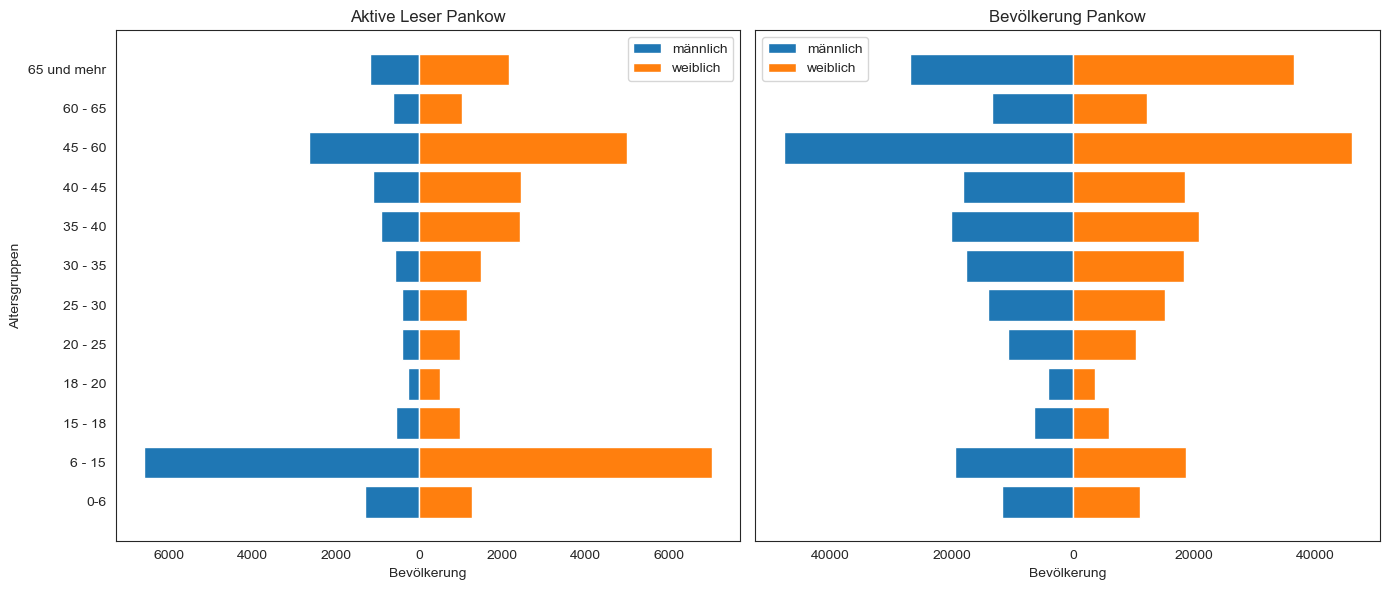

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 0️⃣ Définir les tranches d'âge
# ---------------------------
age_labels = ['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', 
              '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 60', 
              '60 - 65', '65 und mehr']

# ---------------------------
# 1️⃣ Pyramide globale (lecteurs actifs)
# ---------------------------
LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=[0,6,15,18,20,25,30,35,40,45,60,65,200],
    labels=age_labels,
    right=False
)

age_pyramid_global = (
    LesAkt_df.groupby(['Altersgruppe', 'Geschlecht'])
    .size()
    .unstack(fill_value=0)
    .reindex(age_labels, fill_value=0)
)

# Harmoniser noms de colonnes
col_map = {'M': 'Männlich', 'W': 'Weiblich'}
age_pyramid_global = age_pyramid_global.rename(columns=col_map)

# Supprimer colonne 'K' si présente
if 'K' in age_pyramid_global.columns:
    age_pyramid_global = age_pyramid_global.drop(columns=['K'])

# ---------------------------
# 2️⃣ Pyramide Pankow (population)
# ---------------------------
# Charger CSV
Alter_Geschlecht_df = pd.read_csv("Alter vs Geschlecht.csv", sep=';')

# Mettre Altersgruppe en index
if "Altersgruppe" in Alter_Geschlecht_df.columns:
    Alter_Geschlecht_df = Alter_Geschlecht_df.set_index("Altersgruppe")

# Harmoniser éventuels labels différents
mapping = {
    "0 - 6": "0-6",
    "6-15": "6 - 15",
    "65+": "65 und mehr"
}
Alter_Geschlecht_df = Alter_Geschlecht_df.rename(index=mapping)

# Réindexer dans le bon ordre
Alter_Geschlecht_df = Alter_Geschlecht_df.reindex(age_labels, fill_value=0)

# ---------------------------
# 3️⃣ Création du subplot
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# 🔹 Pyramide globale
ax = axes[0]
ax.barh(age_pyramid_global.index, -age_pyramid_global['Männlich'], label='männlich')
ax.barh(age_pyramid_global.index,  age_pyramid_global['Weiblich'], label='weiblich')
ax.set_xlabel("Bevölkerung")
ax.set_ylabel("Altersgruppen")
ax.set_title("Aktive Leser Pankow")
ax.legend()
ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])

# 🔹 Pyramide Pankow
ax2 = axes[1]
ax2.barh(Alter_Geschlecht_df.index, -Alter_Geschlecht_df['Männlich'], label='männlich')
ax2.barh(Alter_Geschlecht_df.index,  Alter_Geschlecht_df['Weiblich'], label='weiblich')
ax2.set_xlabel("Bevölkerung")
ax2.set_title("Bevölkerung Pankow")
ax2.legend()
ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()


Analyse: disproportion enfant/adulte et homme/femme

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/1793924048.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  akt_counts = LesAkt_df.groupby(['Altersgruppe','Geschlecht']).size().reset_index(name="Aktive_Nutzer")


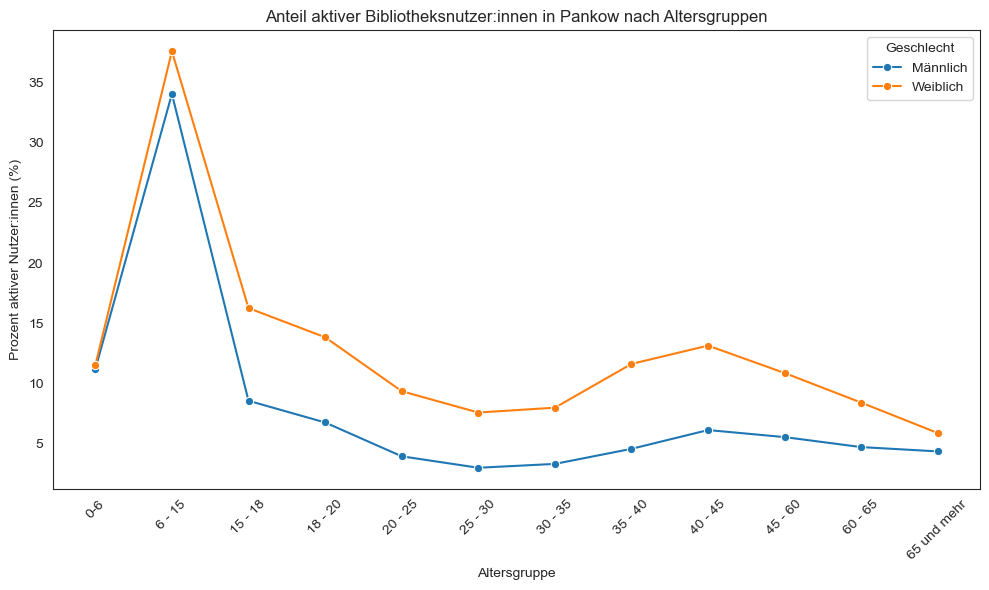

In [57]:
# ---------------------------
# 1️⃣ Catégoriser les âges des usagers actifs
# ---------------------------
age_labels = ['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', 
              '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 60', 
              '60 - 65', '65 und mehr']

LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=[0,6,15,18,20,25,30,35,40,45,60,65,200],
    labels=age_labels,
    right=False
)

# ---------------------------
# 2️⃣ Compter les usagers actifs par tranche et sexe
# ---------------------------
akt_counts = LesAkt_df.groupby(['Altersgruppe','Geschlecht']).size().reset_index(name="Aktive_Nutzer")

# Harmoniser Geschlecht : M → Männlich, W → Weiblich
geschlecht_map = {"M": "Männlich", "W": "Weiblich"}
akt_counts['Geschlecht'] = akt_counts['Geschlecht'].map(geschlecht_map)
# S'assurer que l'index est bien une colonne
Alter_Geschlecht_df = Alter_Geschlecht_df.reset_index().rename(columns={"index": "Altersgruppe"})

# Maintenant on peut passer en long format
pop_long = Alter_Geschlecht_df.melt(
    id_vars="Altersgruppe",
    value_vars=["Männlich", "Weiblich"],
    var_name="Geschlecht",
    value_name="Bevölkerung"
)

# ---------------------------
# 4️⃣ Fusionner population + actifs
# ---------------------------
merged_df = pd.merge(
    pop_long,
    akt_counts,
    on=["Altersgruppe","Geschlecht"],
    how="left"
).fillna(0)

# ---------------------------
# 5️⃣ Calcul du pourcentage
# ---------------------------
merged_df["Prozent_aktiv"] = merged_df["Aktive_Nutzer"] / merged_df["Bevölkerung"] * 100

# ---------------------------
# 6️⃣ Visualisation
# ---------------------------
plt.figure(figsize=(10,6))
sns.lineplot(
    data=merged_df,
    x="Altersgruppe",
    y="Prozent_aktiv",
    hue="Geschlecht",
    marker="o"
)

plt.title("Anteil aktiver Bibliotheksnutzer:innen in Pankow nach Altersgruppen")
plt.xlabel("Altersgruppe")
plt.ylabel("Prozent aktiver Nutzer:innen (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Mapping

In [58]:
LesAkt_df

Sigel Benutzergruppe Geschlecht  Alter Verkehrzelle    PLZ  \
0       462              1          W     52        16112  13187   
2       983              1          M     57        16511  13156   
3       462              6          M      8        16614  13127   
4       462              1          W     39        16011  13187   
5       650              1          W     74        15615  13129   
...     ...            ...        ...    ...          ...    ...   
46112  OPAC              1          W     54        11023  10405   
46113   971              6          W      9        10741  10439   
46114   462              6          M      8        16122  13187   
46115   458              6          W     16        11621  10245   
46116   471              6          M      3        17013  13125   

      Ausweisgültigkeit zuletzt_aktiv Nationalität  Anzahl Altersgruppe  
0            2025-11-04    2025-06-20           DE       1      45 - 60  
2            2025-11-06    2025-07-04           DE       1      45 - 60  
3            2026-01-06    2025-01-06           DE       1       6 - 15  
4            2026-07-22    2025-07-07           DE       1      35 - 40  
5            2026-05-19    2025-06-16           DE       1  65 und mehr  
...                 ...           ...          ...     ...          ...  
46112        2026-01-25    2025-05-15           DE       1      45 - 60  
46113        2025-09-24    2025-07-04           DE       1       6 - 15  
46114        2026-02-06    2025-04-26           DE       1       6 - 15  
46115        2025-05-21    2024-09-13           DE       1      15 - 18  
46116        2026-04-14    2025-06-21           DE       1          0-6  

[43220 rows x 11 columns]

In [59]:
verkehrzelle_df = gpd.read_file("teil_verkehrszellen.geojson")
verkehrzelle_df.head(3)

gml_id spatial_name spatial_alias spatial_type   CODE  \
0  re_vkz_teil.110100111    110100111     110100111      Polygon  00111   
1  re_vkz_teil.110100121    110100121     110100121      Polygon  00121   
2  re_vkz_teil.110100122    110100122     110100122      Polygon  00122   

                                           NAME TYPENO  I_BLN_BZ I_VZ_NR  \
0                    Wiebestraße / Huttenstraße      2         1    0011   
1  An der Putlitzbrücke / Friedrich-Krause-Ufer      3         1    0012   
2                       Großmarkt Beusselstraße      3         1    0012   

   SCHLUESSEL B_NEUE_NR  I_LOR_PRR  I_VBZ122_1  TVZ_881   VBZ_1193 VBZ_TYP_2  \
0           0         1        102   110100112      112  110100112        HK   
1           0         0        102   110100121      121  110100121     RestB   
2           0         1        102   110100111      111  110100111     RestB   

                              VBZ_TYP_3  VBZ_TYP_NO  \
0  großer Hundekopf (mit Typ 1 & 2 & 3)           4   
1   Berlin (außerhalb großer Hundekopf)           5   
2   Berlin (außerhalb großer Hundekopf)           5   

                                            geometry  
0  POLYGON ((13.32467 52.53087, 13.32465 52.53214...  
1  POLYGON ((13.34487 52.53857, 13.34476 52.53847...  
2  POLYGON ((13.31751 52.53238, 13.31788 52.53243...

In [73]:
# Garder uniquement les lignes correspondant à Pankow (3)
vz_pankow = verkehrzelle_df[verkehrzelle_df["I_BLN_BZ"] == 3]

# Vérifier rapidement
vz_pankow.shape
vz_pankow

gml_id spatial_name spatial_alias spatial_type   CODE  \
195  re_vkz_teil.110310611    110310611     110310611      Polygon  10611   
196  re_vkz_teil.110310612    110310612     110310612      Polygon  10612   
197  re_vkz_teil.110310613    110310613     110310613      Polygon  10613   
198  re_vkz_teil.110310614    110310614     110310614      Polygon  10614   
199  re_vkz_teil.110310621    110310621     110310621      Polygon  10621   
..                     ...          ...           ...          ...    ...   
336  re_vkz_teil.110317111    110317111     110317111      Polygon  17111   
337  re_vkz_teil.110317112    110317112     110317112      Polygon  17112   
338  re_vkz_teil.110317113    110317113     110317113      Polygon  17113   
339  re_vkz_teil.110317114    110317114     110317114      Polygon  17114   
340  re_vkz_teil.110317115    110317115     110317115      Polygon  17115   

                                                  NAME TYPENO  I_BLN_BZ  \
195                       Ystader Straße / Gleimstraße      2         3   
196                     Schönhauser Allee / Topsstraße      2         3   
197                  Lychener Straße / Danziger Straße      2         3   
198              Schönhauser Allee / Stargarder Straße      2         3   
199                 Bornholmer Straße / Malmöer Straße      3         3   
..                                                 ...    ...       ...   
336                Zepernicker Straße / Sudauer Straße      3         3   
337                  Alt-Buch / Schwanebecker Chaussee      3         3   
338           Wiltbergstraße / Walter-Friedrich-Straße      3         3   
339              Karower Chaussee / Bruno-Apitz-Straße      3         3   
340  A 10 BAB Berliner Ring / Ernst-Ludwig-Heim-Straße      3         3   

    I_VZ_NR  SCHLUESSEL B_NEUE_NR  I_LOR_PRR  I_VBZ122_1  TVZ_881   VBZ_1193  \
195    1061           0         0        306   110310611    10611  110310611   
196    1061           0         0        306   110310612    10612  110310612   
197    1061           0         0        306   110310613    10613  110310613   
198    1061           0         0        306   110310614    10613  110310614   
199    1062           0         0        306   110310621    10621  110310621   
..      ...         ...       ...        ...         ...      ...        ...   
336    1711           0         0        301   110317111    17111  110317111   
337    1711           0         0        301   110317112    17112  110317112   
338    1711           0         0        301   110317113    17113  110317113   
339    1711           0         0        301   110317114    17114  110317114   
340    1711           0         0        301   110317115    17115  110317115   

    VBZ_TYP_2                             VBZ_TYP_3  VBZ_TYP_NO  \
195        HK  großer Hundekopf (mit Typ 1 & 2 & 3)           4   
196        HK  großer Hundekopf (mit Typ 1 & 2 & 3)           4   
197        HK  großer Hundekopf (mit Typ 1 & 2 & 3)           4   
198        HK  großer Hundekopf (mit Typ 1 & 2 & 3)           4   
199     RestB   Berlin (außerhalb großer Hundekopf)           5   
..        ...                                   ...         ...   
336     RestB   Berlin (außerhalb großer Hundekopf)           5   
337     RestB   Berlin (außerhalb großer Hundekopf)           5   
338     RestB   Berlin (außerhalb großer Hundekopf)           5   
339     RestB   Berlin (außerhalb großer Hundekopf)           5   
340     RestB   Berlin (außerhalb großer Hundekopf)           5   

                                              geometry  
195  POLYGON ((13.40999 52.54615, 13.40988 52.54637...  
196  POLYGON ((13.41312 52.54518, 13.41284 52.54521...  
197  POLYGON ((13.41848 52.54654, 13.41831 52.54633...  
198  POLYGON ((13.41935 52.54775, 13.41913 52.54782...  
199  POLYGON ((13.40886 52.55383, 13.40847 52.55385...  
..                                                 ...  
336  POLYGON ((13.51001 52.64

In [61]:
# Supprimer les lignes où Verkehrzelle est null
LesAkt_df = LesAkt_df.dropna(subset=["Verkehrzelle"])
# Vérifier si tout est bien propre
print(LesAkt_df["Verkehrzelle"].isna().sum())

0


In [62]:
# Fusionner LesAkt_df avec verkehrzelle_df sur les colonnes Verkehrzelle et CODE
LesAkt_geo_df = LesAkt_df.merge(
    vz_pankow[["CODE", "geometry"]],
    left_on="Verkehrzelle",
    right_on="CODE",
    how="left"   # ou "inner" si tu veux garder seulement les correspondances
)

# Vérifier le résultat
LesAkt_geo_df.head(3)


Sigel Benutzergruppe Geschlecht  Alter Verkehrzelle    PLZ  \
0   462              1          W     52        16112  13187   
1   983              1          M     57        16511  13156   
2   462              6          M      8        16614  13127   

  Ausweisgültigkeit zuletzt_aktiv Nationalität  Anzahl Altersgruppe   CODE  \
0        2025-11-04    2025-06-20           DE       1      45 - 60  16112   
1        2025-11-06    2025-07-04           DE       1      45 - 60  16511   
2        2026-01-06    2025-01-06           DE       1       6 - 15  16614   

                                            geometry  
0  POLYGON ((13.40732 52.56465, 13.40681 52.56536...  
1  POLYGON ((13.40206 52.57767, 13.4016 52.57866,...  
2  POLYGON ((13.43205 52.59294, 13.43158 52.59323...

In [63]:
biblio_df = pd.read_csv("Bibliothek Geodata.csv", sep=";")
print(biblio_df.head())


                     Bibliothek       Lat       Lng
0  Bettina-von-Armin-Bibliothek  52.54926  13.41409
1      Bibliothek am Wasserturm  52.53316  13.41951
2                          Buch  52.63564  13.49389
3      Heinrich-Böll-Bibliothek  52.54182  13.44085
4     Janusz-Korczak-Bibliothek  52.56845  13.41236


In [64]:
print(biblio_df.columns.tolist())

['Bibliothek', 'Lat', 'Lng']


In [68]:
%store -r counts_pret
counts_pret.head(3)

CODE  nb_prets
0  00111       312
1  00132        51
2  00211       229

In [74]:
# Fusion des prêts avec les géométries Pankow
gdf_prets_pankow = vz_pankow.merge(
    counts_pret,
    on="CODE",       # colonne commune
    how="inner"      # seulement les codes présents dans vz_pankow
)

# Assurer que c'est un GeoDataFrame
gdf_prets_pankow = gpd.GeoDataFrame(gdf_prets_pankow, geometry="geometry")
gdf_prets_pankow.head(3)


gml_id spatial_name spatial_alias spatial_type   CODE  \
0  re_vkz_teil.110310611    110310611     110310611      Polygon  10611   
1  re_vkz_teil.110310612    110310612     110310612      Polygon  10612   
2  re_vkz_teil.110310613    110310613     110310613      Polygon  10613   

                                NAME TYPENO  I_BLN_BZ I_VZ_NR  SCHLUESSEL  \
0       Ystader Straße / Gleimstraße      2         3    1061           0   
1     Schönhauser Allee / Topsstraße      2         3    1061           0   
2  Lychener Straße / Danziger Straße      2         3    1061           0   

  B_NEUE_NR  I_LOR_PRR  I_VBZ122_1  TVZ_881   VBZ_1193 VBZ_TYP_2  \
0         0        306   110310611    10611  110310611        HK   
1         0        306   110310612    10612  110310612        HK   
2         0        306   110310613    10613  110310613        HK   

                              VBZ_TYP_3  VBZ_TYP_NO  \
0  großer Hundekopf (mit Typ 1 & 2 & 3)           4   
1  großer Hundekopf (mit Typ 1 & 2 & 3)           4   
2  großer Hundekopf (mit Typ 1 & 2 & 3)           4   

                                            geometry  nb_prets  
0  POLYGON ((13.40999 52.54615, 13.40988 52.54637...     19312  
1  POLYGON ((13.41312 52.54518, 13.41284 52.54521...      3292  
2  POLYGON ((13.41848 52.54654, 13.41831 52.54633...     15465

In [75]:
manquants = vz_pankow[~vz_pankow["CODE"].isin(counts_pret["CODE"])]
print("Codes sans prêts :", len(manquants))


Codes sans prêts : 7


In [65]:
# 1️⃣ Compter le nombre d’utilisateurs par CODE
counts = LesAkt_geo_df.groupby("CODE").size().reset_index(name="nb_users")

# 2️⃣ Transformer en GeoDataFrame avec les géométries
gdf = verkehrzelle_df.merge(counts, on="CODE", how="inner")
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")

# 3️⃣ Carte centrée
m = folium.Map(
    location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
    zoom_start=11,
    tiles="cartodbpositron"
)

# 4️⃣ Définir la choropleth
choropleth = folium.Choropleth(
    geo_data=gdf.to_json(),
    data=gdf,
    columns=["CODE", "nb_users"],
    key_on="feature.properties.CODE",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.3,   # plus discret
    legend_name="Nombre d'utilisateurs",
).add_to(m)

for idx, row in biblio_df.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Lng"]],
        popup=folium.Popup(f"{row['Bibliothek']}", max_width=250),
        tooltip=row["Bibliothek"],
        icon=BeautifyIcon(
            icon="book",
            icon_shape="marker",
            background_color="#2ca29c",   # bleu-vert
            text_color="white",
            border_color="#1b7837",
            border_width=1,
            spin=False
        )
    ).add_to(m)


# 5️⃣ Ajout des popups avec style
folium.GeoJson(
    gdf,
    name="zones",
    style_function=lambda feature: {
        "color": "black",       # contour des polygones
        "weight": 0.5,          # épaisseur plus fine
        "fillOpacity": 0        # pas de remplissage supplémentaire
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["CODE", "nb_users"],
        aliases=["Code:", "Utilisateurs:"]
    )
).add_to(m)

m


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/3245991223.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],


In [77]:
m_prets = folium.Map(
    location=[gdf_prets_pankow.geometry.centroid.y.mean(), gdf_prets_pankow.geometry.centroid.x.mean()],
    zoom_start=11,
    tiles="cartodbpositron"
)

choropleth = folium.Choropleth(
    geo_data=gdf_prets_pankow.to_json(),
    data=gdf_prets_pankow,
    columns=["CODE", "nb_prets"],
    key_on="feature.properties.CODE",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name="Nombre de prêts",
).add_to(m_prets)

folium.GeoJson(
    gdf_prets_pankow,
    name="zones",
    style_function=lambda feature: {
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["CODE", "nb_prets"],
        aliases=["Code:", "Prêts:"]
    )
).add_to(m_prets)

m_prets


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/4114282935.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf_prets_pankow.geometry.centroid.y.mean(), gdf_prets_pankow.geometry.centroid.x.mean()],


In [79]:
# =====================
# 1️⃣ Carte de base
# =====================
m = folium.Map(
    location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
    zoom_start=11,
    tiles="cartodbpositron"
)

# =====================
# 2️⃣ Choropleth : Utilisateurs
# =====================
choropleth_users = folium.Choropleth(
    geo_data=gdf.to_json(),
    data=gdf,
    columns=["CODE", "nb_users"],
    key_on="feature.properties.CODE",
    fill_color="YlOrRd",
    fill_opacity=0.6,
    line_opacity=0.3,
    legend_name="Nombre d'utilisateurs",
    name="Utilisateurs"   # <- important pour LayerControl
).add_to(m)

folium.GeoJson(
    gdf,
    name="Zones (utilisateurs)",
    style_function=lambda feature: {
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["CODE", "nb_users"],
        aliases=["Code:", "Utilisateurs:"]
    )
).add_to(m)

# =====================
# 3️⃣ Choropleth : Prêts
# =====================
choropleth_prets = folium.Choropleth(
    geo_data=gdf_prets_pankow.to_json(),
    data=gdf_prets_pankow,
    columns=["CODE", "nb_prets"],
    key_on="feature.properties.CODE",
    fill_color="BuGn",
    fill_opacity=0.6,
    line_opacity=0.3,
    legend_name="Nombre de prêts",
    name="Prêts"   # <- important pour LayerControl
).add_to(m)

folium.GeoJson(
    gdf_prets_pankow,
    name="Zones (prêts)",
    style_function=lambda feature: {
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["CODE", "nb_prets"],
        aliases=["Code:", "Prêts:"]
    )
).add_to(m)

# =====================
# 4️⃣ Ajouter les bibliothèques
# =====================
for idx, row in biblio_df.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Lng"]],
        popup=folium.Popup(f"{row['Bibliothek']}", max_width=250),
        tooltip=row["Bibliothek"],
        icon=BeautifyIcon(
            icon="book",
            icon_shape="marker",
            background_color="#2ca29c",
            text_color="white",
            border_color="#1b7837",
            border_width=1,
            spin=False
        )
    ).add_to(m)

# =====================
# 5️⃣ Contrôle des couches
# =====================
folium.LayerControl().add_to(m)

m


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/3141276395.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],


In [80]:
# =====================
# 1️⃣ Carte de base
# =====================
m = folium.Map(
    location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
    zoom_start=11,
    tiles="cartodbpositron"
)

# =====================
# 2️⃣ Choropleth : Nutzer*innen
# =====================
choropleth_users = folium.Choropleth(
    geo_data=gdf.to_json(),
    data=gdf,
    columns=["CODE", "nb_users"],
    key_on="feature.properties.CODE",
    fill_color="YlOrRd",
    fill_opacity=0.6,
    line_opacity=0.3,
    legend_name="Anzahl der Nutzer*innen",
    name="Nutzer*innen"   # <- Label en allemand
).add_to(m)

folium.GeoJsonTooltip(
    fields=["CODE", "nb_users"],
    aliases=["Code:", "Nutzer*innen:"]
).add_to(choropleth_users.geojson)

# =====================
# 3️⃣ Choropleth : Ausleihen
# =====================
choropleth_prets = folium.Choropleth(
    geo_data=gdf_prets_pankow.to_json(),
    data=gdf_prets_pankow,
    columns=["CODE", "nb_prets"],
    key_on="feature.properties.CODE",
    fill_color="BuGn",
    fill_opacity=0.6,
    line_opacity=0.3,
    legend_name="Anzahl der Ausleihen",
    name="Ausleihen"   # <- Label en allemand
).add_to(m)

folium.GeoJsonTooltip(
    fields=["CODE", "nb_prets"],
    aliases=["Code:", "Ausleihen:"]
).add_to(choropleth_prets.geojson)

# =====================
# 4️⃣ Ajouter les Bibliotheken
# =====================
for idx, row in biblio_df.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Lng"]],
        popup=folium.Popup(f"{row['Bibliothek']}", max_width=250),
        tooltip=row["Bibliothek"],
        icon=BeautifyIcon(
            icon="book",
            icon_shape="marker",
            background_color="#2ca29c",
            text_color="white",
            border_color="#1b7837",
            border_width=1,
            spin=False
        )
    ).add_to(m)

# =====================
# 5️⃣ Contrôle des couches
# =====================
folium.LayerControl().add_to(m)

m


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_1996/2463444544.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],


# The end